# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [12]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

homeo_method = 'HEH'
tag = 'quantization'

matname = tag + '_' + homeo_method
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, homeo_method=homeo_method, eta_homeo=0.05, alpha_homeo=0.02, C=5., nb_quant=128, P_cum=None, verbose=verbose)

In [13]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname='quantization')

Extracting data..loading the data called : data_cache/quantization_data
Data is of shape : (81920, 169) - done in 0.06s.


In [14]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 lolo  staff  2533678 Feb 20 15:12 data_cache/independance_HEH_dico.pkl


In [15]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 lolo  staff  2533678 Feb 20 15:12 data_cache/independance_HEH_dico.pkl


In [16]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 169)
average of patches =  6.8445000669491905e-06  +/-  0.006296589806284218
average energy of data =  0.06112448333671787 +/- 0.06905193929665134


In [17]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/independance_HEH_dico.pkl


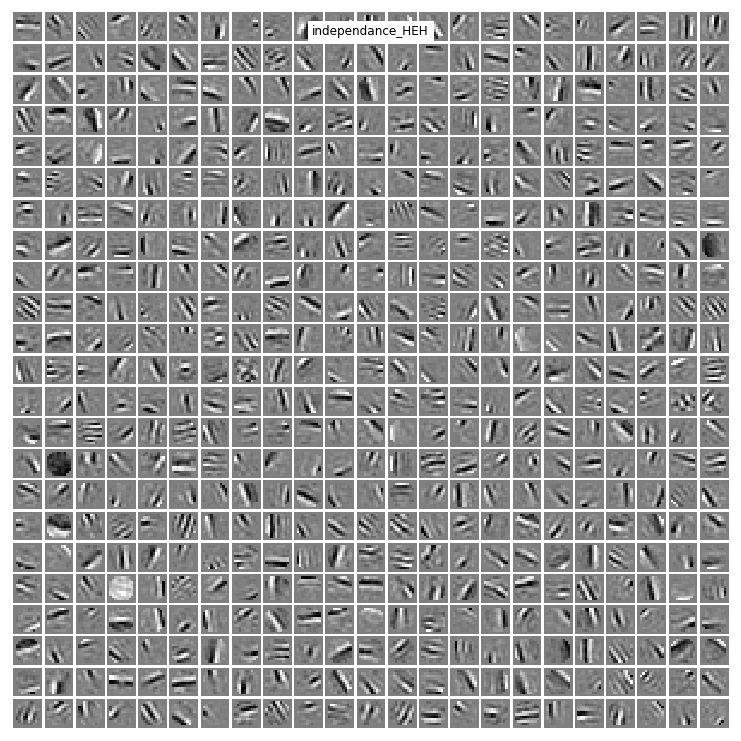

In [18]:
list_figures = ['show_dico']#, 'time_plot_error', 'time_plot_aerror']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [19]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  0.0001661485290286474 +/- 0.008758877783279759
average energy of filters =  1.0 +/- 8.34676118839486e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [20]:
from shl_scripts.shl_encode import mp
nb_quant = 128
record_num_batches = 256
np.random.seed(1973)
indx = np.random.permutation(data.shape[0])[:record_num_batches]
#sparse_code = shl.code(data, dico, matname=matname)
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))
#P_cum = dico.P_cum
#P_cum = None
l0_sparseness = 150
l0_sparseness = shl.l0_sparseness

for P_cum, gain in zip([None, P_cum_zeroeffect, dico.P_cum], [np.ones(shl.n_dictionary), None, None]):
    print(50*'🐒')
    sparse_code = mp(data[indx, :], dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum, gain=gain)

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('average energy of codewords = ', sparse_code.std(axis=0).mean())
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    patches = sparse_code @ dico.dictionary
    print('number of codes, size of reconstructed images = ', patches.shape)

    from shl_scripts.shl_tools import show_data
    max_patches = 10
    fig, axs = show_data(data[indx, :][:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    
    error = (data[indx, :] - patches)
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    print('average error = ', error.mean(), '+/-', error.std())
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒


ValueError: shapes (256,169) and (144,529) not aligned: 169 (dim 1) != 144 (dim 0)

## Quantization of the coefficients

In [ ]:
from shl_scripts.shl_learn import get_P_cum
C = 5.
P_cum = get_P_cum(sparse_code, C=C, nb_quant=nb_quant)
P_cum.shape

In [ ]:
P_cum = dico.P_cum
P_cum.shape

In [ ]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False);
ax.set_ylim(0.85, 1.01);

In [ ]:
P_cum.shape

In [ ]:
from shl_scripts.shl_encode import quantile, rescaling
#sparse_code = mp(data, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum)
stick = np.arange(shl.n_dictionary)*nb_quant
q = quantile(P_cum, rescaling(sparse_code, C=C), stick, do_fast=True)

In [ ]:
from shl_scripts.shl_encode import inv_quantile, inv_rescaling
q_sparse_code = inv_rescaling(inv_quantile(P_cum, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

In [ ]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

In [ ]:
P_cum.mean(axis=0).shape

In [ ]:
P_cum_mean = P_cum.mean(axis=0)[np.newaxis, :] * np.ones((shl.n_dictionary, nb_quant))
fig, ax = plot_P_cum(P_cum_mean, verbose=False);
ax.set_ylim(0.5, 1.01);

In [ ]:
#q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(sparse_code)))
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

In [ ]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

In [ ]:
patches = q_sparse_code @ dico.dictionary
error = data[indx, :] - patches
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
#SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
SD = np.linalg.norm(data[indx, :])/record_num_batches
print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())
#print('total energy of data = ', np.sqrt(np.sum(data**2)))
#print('total deviation of data = ', np.sum(np.abs(data)))
#SE = np.sqrt(np.mean(error**2, axis=1))
SE = np.linalg.norm(error)/record_num_batches

print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
#print('total energy of residual = ', np.sqrt(np.sum(error**2)))
#print('total deviation of residual = ', np.sum(np.abs(error)))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

In [ ]:
P_cum[0, -2]

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts